str

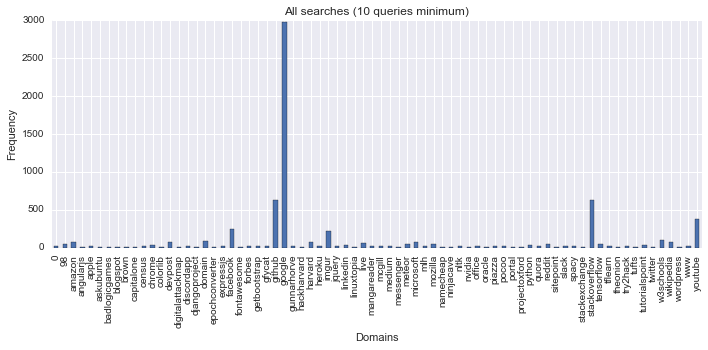

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Top non google/S.O terms per cluster:

('Cluster 0 words:',)
(u' topic',) (u' badlogic',)

('Cluster 1 words:',)
(u' domain',) (u' com',)

('Cluster 2 words:',)
(u' 404',) (u' http',)

('Cluster 3 words:',)
(u' hackharvard',) (u' youtube',)



array([  1.47722553e+12,   1.47722552e+12,   1.47722540e+12, ...,
         1.47709452e+12,   1.47709447e+12,   1.47709447e+12])

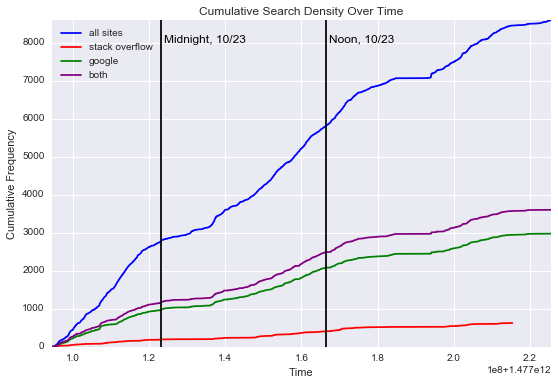

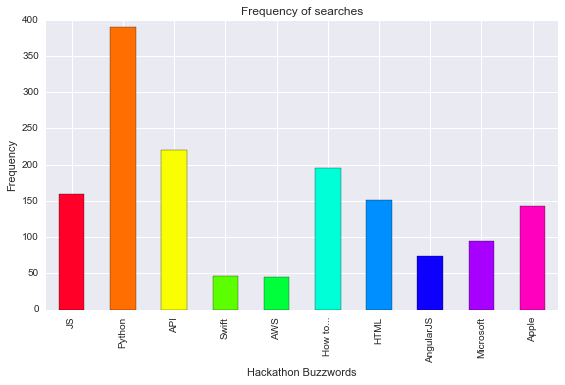

(0.34664183447794206, 0.07298335467349552)

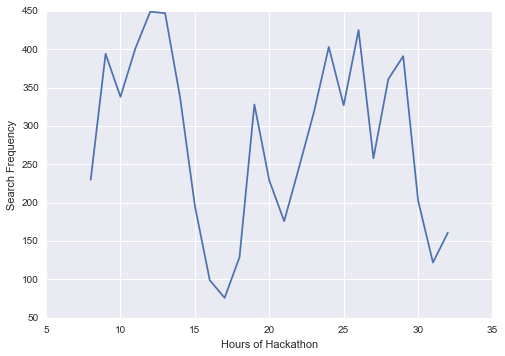

In [4]:
import os
import numpy as np
file_names = []
for fn in os.listdir('../../tmp/historyStorage/'):
    file_names.append(fn)
type(file_names[0])
# file_names

# %load processJSONData.py
# historyStorage_1477123900862362.json
file_searches = []
import json
import seaborn as sns
for i in file_names:
    with open('../../tmp/historyStorage/'+i) as data_file:    
        file_searches.append(json.loads(data_file.read()))


import itertools
searches = list(itertools.chain.from_iterable(file_searches))
# searches

for search in searches:
    url = search['url']
    lastVisitTime = search['lastVisitTime']
    title = search['title']
    typedCount = search['typedCount']
    visitCount = search['visitCount']


dimension = len(searches)
url = []
lastVisitTime = []
title = []
typedCount = []
visitCount = []

for i in range(dimension):
    url.append(str(searches[i]['url']))
    lastVisitTime.append(searches[i]['lastVisitTime'])
    title.append(searches[i]['title'])
    typedCount.append(searches[i]['typedCount'])
    visitCount.append(searches[i]['visitCount'])

import re
def getDomain(url):
    #requires 'http://' or 'https://'
    #pat = r'(https?):\/\/(\w+\.)*(?P<domain>\w+)\.(\w+)(\/.*)?'
    #'http://' or 'https://' is optional
    pat = r'((https?):\/\/)?(\w+\.)*(?P<domain>\w+)\.(\w+)(\/.*)?'
    m = re.match(pat, url)
    if m:
        domain = m.group('domain')
        return domain

domains = []
for i in url:
    domains.append(getDomain(i))

lastVisitTime = np.sort(lastVisitTime)
# time.time()

import time
visitTimes = []
for i in lastVisitTime:
    visitTimes.append(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(i/1000)))

import pandas as pd
import numpy as np
df = pd.DataFrame(data = {'domains': domains, 
                     'visitTimes': visitTimes,
                     'title': title, 
                     'typedCount': typedCount, 
                     'visitCount': visitCount})

# df = df.reindex(index=df.index[::-1], copy=True)
# df.index = range(dimension)
# df

df_counts = df.groupby(df.domains).count()
# df_counts

df_reasonable = df_counts[df_counts['title'] >= 10]

import matplotlib
# %matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=[10,5])
domain_hist = df_reasonable.title.plot(kind="bar")
plt.ylabel('Frequency', ); plt.xlabel('Domains')
plt.title('All searches (10 queries minimum)')
plt.tight_layout()
plt.show()
plt.savefig('domain_frequencies.png', bbox_inches='tight')

# df[df.domains == 'google']

stackoverflow_query = df[df.domains == 'stackoverflow']

google_query = df[df.domains == 'google']

non_google = df[(df.domains != 'google') & (df.domains != 'stackoverflow')]

# non_google
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_df= .8)
# min_df = 0.1 means that the term must be in at least 10% of the documents
X = vectorizer.fit_transform(non_google.title)

from sklearn.cluster import KMeans
k = 4 # Define the number of clusters in which we want to partion our data
# Define the proper notion of distance to deal with documents
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)
# Run the algorithm kmeans
model = KMeans(n_clusters = k)
model.fit(X);

no_words = 2 # Number of words to print per cluster
order_centroids = model.cluster_centers_.argsort()[:, ::-1] # Sort cluster centers by proximity to centroid
terms = vectorizer.get_feature_names()
labels = model.labels_ # Get labels assigned to each data

print("Top non google/S.O terms per cluster:\n")
for i in range(k):
    
#     print("Cluster %d topics:" % i)
#     for title in non_google["title"][labels == i]:
#         print(' %s,' % title)
#     print #add a whitespace

    print("Cluster %d words:" % i,) 
    for ind in order_centroids[i, :no_words]:
        print (' %s' % terms[ind],),
    print
    print

# stackoverflow_query.title

np.flipud(lastVisitTime) 
fixed_int_times = []
for i in lastVisitTime:
    fixed_int_times.append((i - np.mean(lastVisitTime))/np.std(lastVisitTime))

import datetime
midnight = datetime.datetime(2016, 10, 23, 0, 0)
night_start = (midnight-datetime.datetime(1970,1,1)).total_seconds()
# night_start

timezone_diff = datetime.datetime(2016, 10, 22, 8, 0)
true_night_start = (timezone_diff-datetime.datetime(1970,1,1)).total_seconds()
# true_night_start

noon = datetime.datetime(2016, 10, 22, 20, 0)
midday_start = (noon-datetime.datetime(1970,1,1)).total_seconds()
# midday_start

google_search = df[df.domains == 'google']
google_search_times = []
for i in google_search.index:
     google_search_times.append(lastVisitTime[i])
        
df_all_times = []
for i in df.index:
     df_all_times.append(lastVisitTime[i])
        
stackoverflow_search = df[df.domains == 'stackoverflow']
stackoverflow_search_times = []
for i in stackoverflow_search.index:
    stackoverflow_search_times.append(lastVisitTime[i])
    
both_search = df[(df.domains == 'stackoverflow') | (df.domains == 'google')]
both_search_times = []
for i in both_search.index:
    both_search_times.append(lastVisitTime[i])

# plt.figure(figsize=[15,10])
plt.plot(df_all_times,range(len(df_all_times)), c = 'blue', label= 'all sites')
plt.plot(stackoverflow_search_times,range(len(stackoverflow_search_times)), c = 'red', label = 'stack overflow')
plt.plot(google_search_times,range(len(google_search_times)), c = 'green', label = 'google')
plt.plot(both_search_times,range(len(both_search_times)), c = 'purple', label = 'both')
plt.axvline(true_night_start*1000, color = 'black')
plt.text(true_night_start*1000 + 850000, 8000, s = 'Midnight, 10/23', color = 'black')
plt.legend(loc = 'upper left')

plt.axvline(midday_start*1000, color = 'black')
plt.text(midday_start*1000 + 850000, 8000, s = 'Noon, 10/23', color = 'black')

plt.xlabel('Time'); plt.ylabel('Cumulative Frequency')

plt.title('Cumulative Search Density Over Time')
plt.tight_layout()
plt.autoscale(tight=True)
plt.show()
plt.savefig('cumulative_densities.png', bbox_inches='tight')

python_df = df[df['title'].str.contains("python|Python")==True]
javascript_df = df[df['title'].str.contains("javascript|Javascript")==True]
API_df = df[df['title'].str.contains("API")]
swift_df = df[df['title'].str.contains("swift|Swift")==True]
aws_df = df[df['title'].str.contains("aws|AWS")==True]
how_to_df = df[df['title'].str.contains("how to|How to")==True]
html_df = df[df['title'].str.contains("html|HTML|Html")==True]
angularjs_df = df[df['title'].str.contains("AngularJS|angularjs")==True]
microsoft_df = df[df['title'].str.contains("microsoft|Microsoft")==True]
apple_df = df[df['title'].str.contains("Apple|apple|mac|OS")==True]

javascript_hits = len(javascript_df)
python_hits = len(python_df)
API_hits = len(API_df)
swift_hits = len(swift_df)
AWS_hits = len(aws_df)
how_to_hits = len(how_to_df)
html_hits = len(html_df)
angularjs_hits = len(angularjs_df)
microsoft_hits = len(microsoft_df)
apple_hits = len(apple_df)
buzzwords = [javascript_hits, python_hits, API_hits, swift_hits, AWS_hits, how_to_hits, html_hits,
            angularjs_hits, microsoft_hits, apple_hits]

s = pd.Series(
    buzzwords,
    index = ['JS', 'Python', 'API', 'Swift', 'AWS', 'How to...', 'HTML', 
            'AngularJS', 'Microsoft', 'Apple']
)
x = np.arange(len(buzzwords))

#Set descriptions:
plt.title("Frequency of searches")
plt.ylabel('Frequency')
plt.xlabel('Hackathon Buzzwords')

#Set tick colors:
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')

#Plot the data:
cmap = plt.get_cmap('gist_rainbow')
my_colors = [cmap(i) for i in np.linspace(0, 1, 10)]

s.plot( 
    kind='bar', 
    color=my_colors,
)
plt.tight_layout()
plt.show()
plt.savefig('buzzwords.png', bbox_inches='tight')

def CBR_ratio(total_searches, google_searches, stackoverflow_searches):
    google_ratio = len(google_searches) / (len(total_searches) + 0.0)
    stackoverflow_ratio = len(stackoverflow_searches) / (len(total_searches) + 0.0)
    
    return google_ratio, stackoverflow_ratio

CBR_ratio(df_all_times, google_search_times, stackoverflow_search_times)

df_times = np.array(df_all_times) /1000

# df_times

noon = datetime.datetime(2016, 10, 22, 20, 0)
one = datetime.datetime(2016, 10, 22, 21, 0)
hour_time = (one-noon).total_seconds()
# hour_time
total_hours = int((df_times[-1] - df_times[0])/hour_time)
# total_hours

# df

time_stamps = ['2016-10-22 01:00:00',
               '2016-10-22 02:00:00',
               '2016-10-22 03:00:00',
               '2016-10-22 04:00:00',
               '2016-10-22 05:00:00',
               '2016-10-22 06:00:00',
               '2016-10-22 07:00:00',
               '2016-10-22 08:00:00',
               '2016-10-22 09:00:00',
               '2016-10-22 10:00:00',
               '2016-10-22 11:00:00',
               '2016-10-22 12:00:00',
               '2016-10-22 13:00:00',
               '2016-10-22 14:00:00',
               '2016-10-22 15:00:00',
               '2016-10-22 16:00:00',
               '2016-10-22 17:00:00',
               '2016-10-22 18:00:00',
               '2016-10-22 19:00:00',
               '2016-10-22 20:00:00',
               '2016-10-22 21:00:00',
               '2016-10-22 22:00:00',
               '2016-10-22 23:00:00',
               '2016-10-23 00:00:00',
               '2016-10-23 01:00:00',
#                '2016-10-23 02:00:00',
#                '2016-10-23 03:00:00',
#                '2016-10-23 04:00:00',
#                '2016-10-23 05:00:00',
#                '2016-10-23 06:00:00',
#                '2016-10-23 07:00:00',
#                '2016-10-23 08:00:00',
#                '2016-10-23 09:00:00',
#                '2016-10-23 10:00:00',
#                '2016-10-23 11:00:00',
#                '2016-10-23 12:00:00',
#                '2016-10-23 13:00:00',
#                '2016-10-23 14:00:00',
#                '2016-10-23 15:00:00',
#                '2016-10-23 16:00:00',
#                '2016-10-23 17:00:00',
#                '2016-10-23 18:00:00',
#                '2016-10-23 19:00:00',
#                '2016-10-23 20:00:00',
#                '2016-10-23 21:00:00',
#                '2016-10-23 22:00:00',
#                '2016-10-23 23:00:00',
#                '2016-10-24 00:00:00',
#                '2016-10-24 01:00:00',
#                '2016-10-24 02:00:00',
#                '2016-10-24 03:00:00',
#                '2016-10-24 04:00:00',
#                '2016-10-24 05:00:00',
#                '2016-10-24 06:00:00',
#                '2016-10-24 07:00:00',
#                '2016-10-24 08:00:00',
#                '2016-10-24 09:00:00',
              ]

time_index = np.empty([len(time_stamps)])
for i in range(len(time_stamps)):
    if i == 0:
        df_split = df[df.visitTimes < time_stamps[i]]
    else:
        df_split = df[(df.visitTimes < time_stamps[i]) & (df.visitTimes > time_stamps[i-1])]
    time_index[i] = len(df_split)

# time_index

plt.plot(range(8, len(time_stamps) + 8), time_index)
plt.xlabel('Hours of Hackathon'); plt.ylabel('Search Frequency')
plt.savefig('search_histogram.png', bbox_inches='tight')

